In [1]:
!ls

'Data Preprocessing.ipynb'   supermarkets_cleaned_with_popn.csv
'Data Scrapper.ipynb'	     supermarkets_cleaned_with_popn_v2.csv
'Location Analysis.ipynb'    tempmodel.h5
 Model.ipynb		     tempmodel_v2.h5
 supermarkets_cleaned.csv


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# from pykeops.torch import LazyTensor
from sklearn.cluster import KMeans

In [2]:
#Read Data, Drop unnecessary column and change - in rating to -1
supermarkets = pd.read_csv('supermarkets_cleaned_with_popn_v2.csv')
supermarkets.drop('Unnamed: 0', axis=1, inplace=True)
supermarkets.loc[supermarkets['rating']=='-', 'rating'] = -1
supermarkets.loc[supermarkets['rating']=='0.0', 'rating'] = -1
supermarkets.rating = supermarkets.rating.map(float)
supermarkets.head()


,business_status,name,latitude,longitude,rating,atms,banks,bus_stations,churches,gas_stations,...,mosques,pharmacies,restaurants,schools,train_stations,Males,Females,Children,Working,Elderly
0,OPERATIONAL,"AllMart Plus, Ayat Neighborhood, Addis Ababa",9.020171,38.875108,-1.0,1,9,0,7,3,...,0,2,28,4,0,145225,163770,75491,225517,7987
1,OPERATIONAL,Nahuta SuperMarket,9.022502,38.785852,5.0,8,36,0,15,1,...,4,9,105,28,0,161592,185072,83403,251219,12042
2,OPERATIONAL,Afran Mini Market,9.057363,38.724341,-1.0,0,15,0,9,2,...,9,6,54,20,0,129396,138228,61641,195556,10427
3,OPERATIONAL,251 Store ET Gerji store,9.001777,38.810458,-1.0,1,27,0,11,1,...,0,13,153,27,0,145225,163770,75491,225517,7987
4,OPERATIONAL,Selam Super Market,9.011199,38.796551,-1.0,1,34,0,22,6,...,1,9,110,21,0,145225,163770,75491,225517,7987


In [6]:
# sns.pairplot(supermarkets,y_vars=supermarkets['rating'])

In [27]:
#Plot histogram to show distribution of features among the highest ranked supermarkets
columns = supermarkets.columns
rating_highest = supermarkets[supermarkets['rating']>4.0]
for col in columns:
    if col not in {'rating', 'business_status', 'name', 'latitude', 'longitude'}:
        rating_highest[col].plot.hist(bins = 10, alpha=0.5,title = col)
        plt.show()

In [3]:
#Try Kmeans to fill out the missing values
km = KMeans(n_clusters=6)
x = supermarkets.drop(['rating', 'business_status', 'name', 'latitude', 'longitude', 'bus_stations','train_stations'],axis=1).values
yp = km.fit_predict(x)
# supermarkets['predicted_rating'] = yp
supermarkets[['rating', 'predicted_rating']].head(30)

In [29]:
supermarkets.loc[supermarkets['rating']==-1.0, 'rating'] = np.random.choice([1.0,2.0,3.0,4.0,5.0])
supermarkets['rating'] = np.around(supermarkets['rating'].astype(np.float))
supermarkets['rating'] = supermarkets['rating'].map(int)
supermarkets['rating'].value_counts()

2    854
5    228
4    225
3     59
1     22
Name: rating, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split

X = supermarkets.drop(['business_status','name','latitude','longitude', 'rating','bus_stations','train_stations'], axis=1).values
y = supermarkets['rating'].values

X, y = torch.tensor(X), torch.tensor(y)


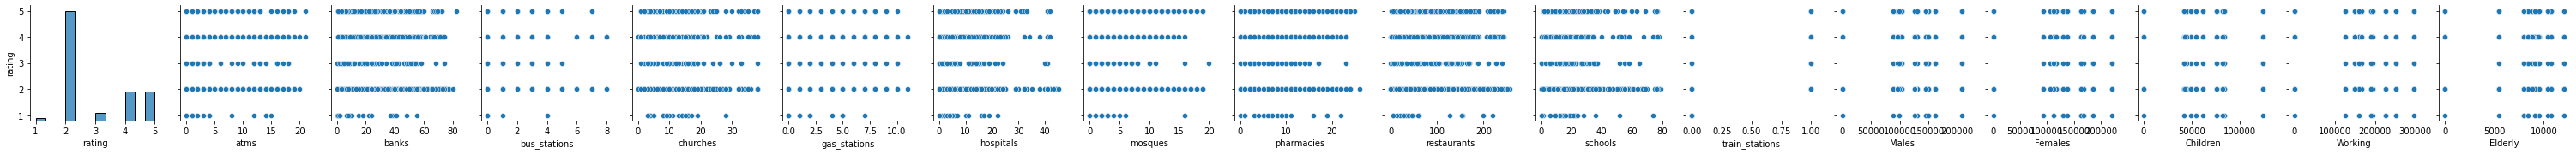

In [17]:
# cleaned = supermarkets.drop(['business_status','name','latitude','longitude', 'rating','bus_stations','train_stations'], axis=1)
data = data
data = data.drop(['business_status','name','latitude','longitude'],axis=1)
sns.pairplot(data, y_vars='rating')
# data.head()

In [49]:
data.corr()

,latitude,longitude,rating,atms,banks,bus_stations,churches,gas_stations,hospitals,mosques,...,restaurants,schools,train_stations,Males,Females,Children,Working,Elderly,new_rating,rating_grade
latitude,1.000000,0.133916,0.041173,0.100778,0.137618,0.163205,0.089656,0.168417,0.105964,0.263745,...,0.107297,0.229993,0.026301,0.022787,0.015699,-0.070564,0.045580,0.431454,0.020424,0.006485
longitude,0.133916,1.000000,-0.056665,0.061632,-0.014823,-0.087415,-0.020004,-0.231917,-0.054257,-0.501699,...,0.042721,-0.161938,-0.067304,-0.009269,0.054381,-0.047487,0.056957,0.031464,0.026071,0.193310
rating,0.041173,-0.056665,1.000000,-0.015393,0.007102,-0.012902,-0.031469,0.021489,0.008673,0.100469,...,0.001605,0.008993,-0.004776,0.053814,0.046810,0.044191,0.049331,0.101359,0.050244,0.058434
atms,0.100778,0.061632,-0.015393,1.000000,0.855719,0.505103,0.354136,0.339390,0.429401,0.019342,...,0.782182,0.332048,0.298460,-0.159120,-0.131931,-0.211371,-0.114120,0.001621,-0.143361,-0.117579
banks,0.137618,-0.014823,0.007102,0.855719,1.000000,0.463233,0.499623,0.496545,0.650408,0.139316,...,0.876599,0.506802,0.285667,-0.244215,-0.219279,-0.333615,-0.188303,0.120211,-0.229220,-0.230886
bus_stations,0.163205,-0.087415,-0.012902,0.505103,0.463233,1.000000,0.312119,0.627349,0.149969,0.143877,...,0.225273,0.276780,0.682717,-0.289638,-0.277417,-0.331909,-0.265036,0.088120,-0.282325,-0.269002
churches,0.089656,-0.020004,-0.031469,0.354136,0.499623,0.312119,1.000000,0.267520,0.639800,-0.048328,...,0.389913,0.731109,0.145459,-0.118683,-0.084322,-0.184533,-0.068899,0.198591,-0.098546,-0.079795
gas_stations,0.168417,-0.231917,0.021489,0.339390,0.496545,0.627349,0.267520,1.000000,0.292047,0.440817,...,0.328886,0.319952,0.389804,-0.393052,-0.401177,-0.470549,-0.372866,0.211305,-0.396581,-0.400666
hospitals,0.105964,-0.054257,0.008673,0.429401,0.650408,0.149969,0.639800,0.292047,1.000000,0.086163,...,0.619769,0.655366,0.003571,-0.194701,-0.174136,-0.262714,-0.153187,0.149702,-0.182220,-0.159373
mosques,0.263745,-0.501699,0.100469,0.019342,0.139316,0.143877,-0.048328,0.440817,0.086163,1.000000,...,0.120744,0.146395,0.017327,-0.012415,-0.072071,-0.058383,-0.045522,0.225638,-0.044610,-0.169934


In [28]:
'''
columns = ['rating', 'atms',
       'banks', 'bus_stations', 'churches', 'gas_stations', 'hospitals',
       'mosques', 'pharmacies', 'restaurants', 'schools', 'train_stations',
       'Males', 'Females', 'Children', 'Working', 'Elderly']
'''
def get_rating():    
       data['new_rating'] = 0.4 * data['rating'] + 0.4 * data['atms'] + 0.5 *data['banks'] \
              + 0.4 * data['churches'] + 0.4 * data['gas_stations'] + 0.5 *data['hospitals'] \
              + 0.4 * data['mosques'] + 0.4 * data['pharmacies'] + 0.5 *data['restaurants'] \
              + 0.4 * data['schools'] + 0.4 * data['Males'] + 0.5 *data['Females'] \
              + 0.4 * data['Children'] + 0.4 * data['Working'] + 0.5 *data['Elderly']  
# get_rating()
data.head()
# data = supermarkets.loc[supermarkets['rating']>-1.0]


# data['new_rating']
# print(len(supermarkets))

,business_status,name,latitude,longitude,rating,atms,banks,bus_stations,churches,gas_stations,...,restaurants,schools,train_stations,Males,Females,Children,Working,Elderly,new_rating,rating_grade
1,OPERATIONAL,Nahuta SuperMarket,9.022502,38.785852,5.0,8,36,0,15,1,...,105,28,0,161592,185072,83403,251219,12042,297150.10,5
10,OPERATIONAL,ሐዋርያው ቅዱስ ፊሊጶስ ቤ/ክ ጆን ኤማንዳ ሚኒ ማርኬት,9.041952,38.704914,5.0,0,3,0,8,0,...,18,15,0,207641,221254,123704,295646,9545,366228.00,5
11,OPERATIONAL,Abadir Supermarket,9.019505,38.814831,3.8,2,16,0,16,2,...,57,11,0,145225,163770,75491,225517,7987,264425.32,4
12,OPERATIONAL,Ali Mini Market,9.038220,38.748040,5.0,9,40,3,13,7,...,182,39,0,99165,112336,42050,160343,9108,181503.20,3
16,OPERATIONAL,Kuter 9 Supermarket,9.004802,38.752306,4.5,3,35,4,20,6,...,113,22,1,103500,117734,44236,167565,9433,189808.70,3


In [22]:
print('STD: ', data.new_rating.std())
print('mean: ', data.new_rating.mean())
print('median: ', data.new_rating.median())
print('min: ', data.new_rating.min())
print('max: ', data.new_rating.max())


STD:  62469.635427664005
mean:  241443.66410909078
median:  264427.05000000005
min:  2.5
max:  366254.4


In [27]:
# data['rating_grade'] = 0
# data.head()
for i, row in data.iterrows():
    ifor_val = -1
    if row['new_rating'] < 41443:
        ifor_val = 1
    elif row['new_rating'] < 141443:
        ifor_val = 2
    elif row['new_rating'] < 251443:
        ifor_val = 3
    elif row['new_rating'] < 291443:
        ifor_val = 4
    elif row['new_rating'] < 376254:
        ifor_val = 5
    data.at[i,'rating_grade'] = ifor_val

In [32]:
from sklearn.model_selection import train_test_split

X = data.drop(['business_status','name','latitude','longitude', 'rating','bus_stations','train_stations','new_rating','rating_grade'], axis=1).values
y = data['rating_grade'].values

X, y = torch.tensor(X), torch.tensor(y)

def one_hot_encode(vector):
    n_classes = len(vector.unique())
    one_hot = torch.zeros((vector.shape[0], n_classes)).type(torch.LongTensor)
    vector_type = vector.type(torch.LongTensor).unsqueeze(1)
    return one_hot.scatter(0, vector_type, 1)
y_one_hot = one_hot_encode(y)
# data.columns

In [33]:
# random_indices = torch.randperm(X.shape[0])

n_train = int(0.8 * X.shape[0])

X_train = X[:n_train]
X_test = X[n_train:]

y_train = y[:n_train]
y_test = y[n_train:]

y_train_one_hot = y_one_hot[:n_train]
y_test_one_hot = y_one_hot[n_train:]

In [45]:
model = torch.nn.Sequential(
    torch.nn.Linear(14, 6),
    # torch.nn.Linear(120, 5)
)

In [46]:
learning_rate = 0.01
lambda_param = 0.001
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=lambda_param
)

In [47]:
loss_function = torch.nn.CrossEntropyLoss()

In [48]:
n_iterations = 5000
for i in range(1, n_iterations + 1):
    Z = model(X_train.float())
    # print(Z)
    
    loss = loss_function(Z, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i == 1 or i % 50 == 0:
        print("Loss at iteration {}: {}".format(i, loss))

test_predictions = torch.argmax(
    torch.softmax(model(X_test.float()), 1), axis=1
)
test_accuracy = float(sum(test_predictions == y_test)) / y_test.shape[0]
print("\nFinal Test Accuracy: {}".format(test_accuracy))

Loss at iteration 1: 104022.7578125
Loss at iteration 50: 207264576.0
Loss at iteration 100: 243864656.0
Loss at iteration 150: 105844776.0
Loss at iteration 200: 220698832.0
Loss at iteration 250: 193191744.0
Loss at iteration 300: 363289440.0
Loss at iteration 350: 212201216.0
Loss at iteration 400: 196619840.0
Loss at iteration 450: 142615456.0
Loss at iteration 500: 208772928.0
Loss at iteration 550: 139341856.0
Loss at iteration 600: 264838560.0
Loss at iteration 650: 97110976.0
Loss at iteration 700: 166363936.0
Loss at iteration 750: 106889056.0
Loss at iteration 800: 180428768.0
Loss at iteration 850: 72967480.0
Loss at iteration 900: 39696928.0
Loss at iteration 950: 297360832.0
Loss at iteration 1000: 27228498.0
Loss at iteration 1050: 140416368.0
Loss at iteration 1100: 270263616.0
Loss at iteration 1150: 103542440.0
Loss at iteration 1200: 184264288.0
Loss at iteration 1250: 162133920.0
Loss at iteration 1300: 195059040.0
Loss at iteration 1350: 16658267.0
Loss at iteration

In [14]:
torch.save(model, 'tempmodel_v2.h5')

In [15]:
l = torch.load('tempmodel_v2.h5')
test_values = torch.tensor([[15.0,41.0,85.0,70.0,36.0,30.0,15.0,20.0,16.0,40.0,20.0,15000, 15000, 10000,15000, 5000]])
torch.argmax(
torch.softmax(l(test_values), 1)
    , axis=1
)

tensor([5])

In [37]:
X_train.shape

torch.Size([1110, 15])